In [0]:
import os
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt

from scipy import stats

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import sklearn
#from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, mean_squared_error, log_loss

from pandas_profiling import ProfileReport

##Defining Functions

In [0]:
'''Model Functions'''

def Naive_Bayes(features, target):
    '''Function to Train Naive Bayes Classifier'''
    gnb = GaussianNB()
    gnb.fit(features, target)
    return gnb

def Decision_Tree(features, target):
    '''Function to Train Decision Tree Classifier'''
    dt = DecisionTreeClassifier(class_weight={0: 1, 1: 3})
    dt.fit(features, target)
    return dt

def Random_Forest(features, target):
    '''Function to Random Forest Classifier'''
    rf = RandomForestClassifier(class_weight={0: 1, 1: 5})
    rf.fit(features,target)
    return rf

def Knn(features, target):
    '''Function to Knn Classifier'''
    knn = KNeighborsClassifier()
    knn.fit(features, target)
    return knn

def SVM(features, target):
    '''Function to SVM Classifier'''
    svm = LinearSVC()
    svm.fit(features, target)
    return svm

def Logistic_Reg(features, target):
    '''Function to SVM Classifier'''
    lr = LogisticRegression()
    lr.fit(features, target)
    return lr
  
def Gradient_Boost(features, target):
    '''Function to Train Gradient Boosting Classifier'''
    gbm = GradientBoostingClassifier(random_state=100)
    gbm.fit(features, target)
    return gbm

In [0]:

'''Evaluation Functions'''
def con_matrix(test_actual, test_predictions,model_name):
    labels=['1','0']
    #cm = confusion_matrix(test_actual, test_predictions, labels)
    cm = confusion_matrix(test_actual, test_predictions,labels = [1,0])
    confusion_mat = pd.DataFrame(data=cm[0:,0:],    # values
                                 index=labels,    # 1st column as index
                                 columns=labels)  # 1st row as the column names
    print('The Confusion Matrix of the',model_name,'\n',confusion_mat)


def score_calc(model_object, test_features, test_actual, test_predictions, model_name):
    Accuracy = metrics.accuracy_score(test_actual,test_predictions)
    recall_list = []
    #recall = metrics.recall_score(test_actual,test_predictions,pos_label ='Good Return').tolist()
    #precision = metrics.precision_score(test_actual,test_predictions,pos_label ='Good Return').tolist()
    #f1 = metrics.f1_score(test_actual,test_predictions,pos_label ='Good Return').tolist()
    recall = metrics.recall_score(test_actual,test_predictions).tolist()
    precision = metrics.precision_score(test_actual,test_predictions).tolist()
    f1 = metrics.f1_score(test_actual,test_predictions).tolist()
    test_pred_probability = model_object.predict_proba(test_features)
    auc = roc_auc_score(test_actual, test_pred_probability[:,1])
    
    recall_list.append(recall)
    mod_result = pd.DataFrame(recall_list,columns=['Recall'])
    mod_result['Precision'] = precision
    mod_result['F1'] = f1
    mod_result['Accuracy'] = Accuracy
    mod_result['AUC'] = auc
    mod_result['Model_Type'] = model_name
    
    return mod_result

In [0]:

def print_model_stats(model_object, xtrain, ytrain, xtest, ytest):
    '''
        Objective: To print required model statistics 
        Arguments: 6 arguments
                    1) Model Object
                    2) training dataset for features
                    3) training dataset for target
                    4) testing dataset for features
                    5) testing dataset for target
                    6) name of the target variable
           
        Output   : All key model statistics like AUC, Lift chart etc.

    '''

    prob_y2 = model_object.predict_proba(xtest)

    print ("--------------------------------------------------------------------")

    print( "Model Statistics on Validation dataset")

    print ("Log Loss Without for validation sample:", \
                    log_loss(ytest, prob_y2[:,1],eps=1e-15, normalize=True))

    print ("ROC-AUC score for the validation sample: %.3f" \
                                      % roc_auc_score(ytest, prob_y2[:,1]))

    
    print ("ROC curve for the Validaton Sample")
    plot_roc(ytest.values.ravel(), prob_y2[:,1])
    plt.gcf().clear()

In [0]:

def plot_roc(ytest,yprob):
        '''
        Objective: Function to plot ROC Graph
        Argument : ytest: Actual Take up rate(1/0), yprob: predcicted probabilities
        Returns  : ROC Plot
        Output   : ROC Plot

        '''
        fig = plt.figure(1, figsize=(6, 6))

        false_positive_rate, true_positive_rate, thresholds = \
        roc_curve(ytest, yprob)

        roc_auc = auc(false_positive_rate, true_positive_rate)

        plt.title("Receiving Operator Characteristic")

        plt.plot(false_positive_rate, true_positive_rate, 'b', \
        label='AUC = %0.2f' % roc_auc)

        plt.legend(loc='lower right')
        plt.plot([0,1], [0,1], 'r--')
        plt.xlim([-0.1, 1.2])
        plt.ylim([-0.1, 1.2])
        plt.ylabel("True Positive Rate")
        plt.xlabel("False Positive Rate")
        plt.tight_layout()

        nfig = plt.figure(2, figsize=(6, 6))
        return plt.show()

In [0]:
def decision_tree_regressor_predict_proba(X_train, y_train, X_test, **kwargs):
    """Trains DecisionTreeRegressor model and predicts probabilities of each y.

    Args:
        X_train: Training features.
        y_train: Training labels.
        X_test: New data to predict on.
        **kwargs: Other arguments passed to DecisionTreeRegressor.

    Returns:
        DataFrame with columns for record_id (row of X_test), y 
        (predicted value), and prob (of that y value).
        The sum of prob equals 1 for each record_id.
    """
    # Train model.
    m = DecisionTreeRegressor(**kwargs).fit(X_train, y_train)
    # Get y values corresponding to each node.
    node_ys = pd.DataFrame({'node_id': m.apply(X_train), 'y': y_train})
    # Calculate probability as 1 / number of y values per node.
    node_ys['prob'] = 1 / node_ys.groupby(node_ys.node_id).transform('count')
    # Aggregate per node-y, in case of multiple training records with the same y.
    node_ys_dedup = node_ys.groupby(['node_id', 'y']).prob.sum().to_frame()\
        .reset_index()
    # Extract predicted leaf node for each new observation.
    leaf = pd.DataFrame(m.decision_path(X_test).toarray()).apply(
        lambda x:x.to_numpy().nonzero()[0].max(), axis=1).to_frame(
            name='node_id')
    leaf['record_id'] = leaf.index
    # Merge with y values and drop node_id.
    return leaf.merge(node_ys_dedup, on='node_id').drop(
        'node_id', axis=1).sort_values(['record_id', 'y'])

##Reading Training Data

In [0]:
loan_application = pd.read_csv("/dbfs/mnt/agorizeblob/loan_data/application_data.csv")
 
loan_application.tail()

Out[7]:

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,0.032561,-9327,-236,-8456.0,-1982,NaN,1,1,0,1,0,0,Sales staff,1.0,1,1,THURSDAY,15,0,0,0,0,0,0,...,0.1509,0.2001,0.0757,0.1118,reg oper account,block of flats,0.2898,"Stone, brick",No,0.0,0.0,0.0,0.0,-273.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,225000.0,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,0.025164,-20775,365243,-4388.0,-4090,NaN,1,0,0,1,1,0,NaN,1.0,2,2,MONDAY,8,0,0,0,0,0,0,...,0.0205,0.0261,0.0000,0.0000,reg oper account,block of flats,0.0214,"Stone, brick",No,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,585000.0,Unaccompanied,Working,Higher education,Separated,House / apartment,0.005002,-14966,-7921,-6737.0,-5150,NaN,1,1,0,1,0,1,Managers,1.0,3,3,THURSDAY,9,0,0,0,0,1,1,...,0.0855,0.9445,0.0000,0.0000,reg oper account,block of flats,0.7970,Panel,No,6.0,0.0,6.0,0.0,-1909.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,319500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.005313,-11961,-4786,-2562.0,-931,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,9,0,0,0,1,1,0,...,NaN,0.0062,NaN,NaN,NaN,block of flats,0.0086,"Stone, brick",No,0.0,0.0,0.0,0.0,-322.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
307510,456255,0,Cash loans,F,N,N,0,157500.0,675000.0,49117.5,675000.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.046220,-16856,-1262,-5128.0,-410,NaN,1,1,1,1,1,0,Laborers,2.0,1,1,THURSDAY,20,0,0,0,0,1,1,...,NaN,0.0805,NaN,0.0000,NaN,block of flats,0.0718,Panel,No,0.0,0.0,0.0,0.0,-787.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,2.0,0.0,1.0


In [0]:
loan_application.dtypes

Out[8]: SK_ID_CURR int64
TARGET int64
NAME_CONTRACT_TYPE object
CODE_GENDER object
FLAG_OWN_CAR object
 ... 
AMT_REQ_CREDIT_BUREAU_DAY float64
AMT_REQ_CREDIT_BUREAU_WEEK float64
AMT_REQ_CREDIT_BUREAU_MON float64
AMT_REQ_CREDIT_BUREAU_QRT float64
AMT_REQ_CREDIT_BUREAU_YEAR float64
Length: 122, dtype: object

In [0]:
#changing the data type
loan_application['TARGET'] = loan_application['TARGET'].astype('str')

In [0]:
#profiling the dataset
profile_loan_df = ProfileReport(loan_application, title="Loan Application DF Profile Report")

In [0]:
profile_loan_df.to_widgets()

Summarize dataset: 0%| | 0/135 [00:00<?, ?it/s]Summarize dataset: 0%| | 0/135 [00:06<?, ?it/s, Describe variable:TARGET]Summarize dataset: 1%| | 1/135 [00:06<13:58, 6.26s/it, Describe variable:TARGET]Summarize dataset: 1%| | 1/135 [00:06<13:58, 6.26s/it, Describe variable:CODE_GENDER]Summarize dataset: 1%|▏ | 2/135 [00:06<06:10, 2.78s/it, Describe variable:CODE_GENDER]Summarize dataset: 1%|▏ | 2/135 [00:07<06:10, 2.78s/it, Describe variable:NAME_CONTRACT_TYPE]Summarize dataset: 2%|▏ | 3/135 [00:07<03:50, 1.74s/it, Describe variable:NAME_CONTRACT_TYPE]Summarize dataset: 2%|▏ | 3/135 [00:07<03:50, 1.74s/it, Describe variable:SK_ID_CURR] Summarize dataset: 3%|▎ | 4/135 [00:07<02:39, 1.22s/it, Describe variable:SK_ID_CURR]Summarize dataset: 3%|▎ | 4/135 [00:08<02:39, 1.22s/it, Describe variable:FLAG_OWN_CAR]Summarize dataset: 4%|▎ | 5/135 [00:08<02:17, 1.06s/it, Describe variable:FLAG_OWN_CAR]Summarize dataset: 4%|▎ | 5/135 [00:08<02:17, 1.06s/it, Describe variable:FLAG_OWN_REALTY]Summarize dataset: 4%|▍ | 6/135 [00:08<02:16, 1.06s/it, Describe variable:CNT_CHILDREN] Summarize dataset: 5%|▌ | 7/135 [00:08<01:10, 1.82it/s, Describe variable:CNT_CHILDREN]Summarize dataset: 5%|▌ | 7/135 [00:08<01:10, 1.82it/s, Describe variable:AMT_INCOME_TOTAL]Summarize dataset: 6%|▌ | 8/135 [00:08<01:09, 1.82it/s, Describe variable:AMT_CREDIT] Summarize dataset: 7%|▋ | 9/135 [00:08<00:54, 2.33it/s, Describe variable:AMT_CREDIT]Summarize dataset: 7%|▋ | 9/135 [00:09<00:54, 2.33it/s, Describe variable:AMT_GOODS_PRICE]Summarize dataset: 7%|▋ | 10/135 [00:09<00:55, 2.24it/s, Describe variable:AMT_GOODS_PRICE]Summarize dataset: 7%|▋ | 10/135 [00:09<00:55, 2.24it/s, Describe variable:AMT_ANNUITY] Summarize dataset: 8%|▊ | 11/135 [00:09<00:58, 2.13it/s, Describe variable:AMT_ANNUITY]Summarize dataset: 8%|▊ | 11/135 [00:16<00:58, 2.13it/s, Describe variable:NAME_TYPE_SUITE]Summarize dataset: 9%|▉ | 12/135 [00:16<04:26, 2.17s/it, Describe variable:NAME_TYPE_SUITE]Summarize dataset: 9%|▉ | 12/135 [00:17<04:26, 2.17s/it, Describe variable:NAME_INCOME_TYPE]Summarize dataset: 10%|▉ | 13/135 [00:19<04:24, 2.17s/it, Describe variable:NAME_EDUCATION_TYPE]Summarize dataset: 10%|█ | 14/135 [00:19<03:24, 1.69s/it, Describe variable:NAME_EDUCATION_TYPE]Summarize dataset: 10%|█ | 14/135 [00:19<03:24, 1.69s/it, Describe variable:NAME_FAMILY_STATUS] Summarize dataset: 11%|█ | 15/135 [00:19<02:41, 1.34s/it, Describe variable:NAME_FAMILY_STATUS]Summarize dataset: 11%|█ | 15/135 [00:19<02:41, 1.34s/it, Describe variable:REGION_POPULATION_RELATIVE]Summarize dataset: 12%|█▏ | 16/135 [00:20<02:39, 1.34s/it, Describe variable:DAYS_BIRTH] Summarize dataset: 13%|█▎ | 17/135 [00:20<02:05, 1.07s/it, Describe variable:DAYS_BIRTH]Summarize dataset: 13%|█▎ | 17/135 [00:20<02:05, 1.07s/it, Describe variable:DAYS_EMPLOYED]Summarize dataset: 13%|█▎ | 18/135 [00:20<01:42, 1.14it/s, Describe variable:DAYS_EMPLOYED]Summarize dataset: 13%|█▎ | 18/135 [00:20<01:42, 1.14it/s, Describe variable:DAYS_REGISTRATION]Summarize dataset: 14%|█▍ | 19/135 [00:21<01:41, 1.14it/s, Describe variable:NAME_HOUSING_TYPE]Summarize dataset: 15%|█▍ | 20/135 [00:21<01:24, 1.36it/s, Describe variable:NAME_HOUSING_TYPE]Summarize dataset: 15%|█▍ | 20/135 [00:24<01:24, 1.36it/s, Describe variable:OWN_CAR_AGE] Summarize dataset: 16%|█▌ | 21/135 [00:24<02:01, 1.06s/it, Describe variable:OWN_CAR_AGE]Summarize dataset: 16%|█▌ | 21/135 [00:24<02:01, 1.06s/it, Describe variable:DAYS_ID_PUBLISH]Summarize dataset: 16%|█▋ | 22/135 [00:24<01:43, 1.09it/s, Describe variable:DAYS_ID_PUBLISH]Summarize dataset: 16%|█▋ | 22/135 [00:30<01:43, 1.09it/s, Describe variable:FLAG_MOBIL] Summarize dataset: 17%|█▋ | 23/135 [00:30<04:14, 2.27s/it, Describe variable:FLAG_MOBIL]Summarize dataset: 17%|█▋ | 23/135 [00:31<04:14, 2.27s/it, Describe variable:FLAG_EMP_PHONE]Summarize dataset: 18%|█▊ | 24/135 [00:31<03:24, 1.84s/it, Describe variable:FLAG_EMP_PHONE]Summarize dataset: 18%|█▊ | 24/135 [00:35

--------------------------------------------------------------------------- 
 _RemoteTraceback Traceback (most recent call last)
 _RemoteTraceback : 
"""
Traceback (most recent call last):
 File "/databricks/python/lib/python3.8/site-packages/joblib/externals/loky/backend/queues.py", line 153, in _feed
 obj_ = dumps(obj, reducers=reducers)
 File "/databricks/python/lib/python3.8/site-packages/joblib/externals/loky/backend/reduction.py", line 271, in dumps
 dump(obj, buf, reducers=reducers, protocol=protocol)
 File "/databricks/python/lib/python3.8/site-packages/joblib/externals/loky/backend/reduction.py", line 264, in dump
 _LokyPickler(file, reducers=reducers, protocol=protocol).dump(obj)
 File "/databricks/python/lib/python3.8/site-packages/joblib/externals/cloudpickle/cloudpickle_fast.py", line 563, in dump
 return Pickler.dump(self, obj)
 File "/databricks/python/lib/python3.8/site-packages/joblib/_memmapping_reducer.py", line 442, in __call__
 for dumped_filename in dump(a, filename):
 File "/databricks/python/lib/python3.8/site-packages/joblib/numpy_pickle.py", line 480, in dump
 NumpyPickler(f, protocol=protocol).dump(value)
 File "/usr/local/lib/python3.8/pickle.py", line 485, in dump
 self.save(obj)
 File "/databricks/python/lib/python3.8/site-packages/joblib/numpy_pickle.py", line 279, in save
 wrapper.write_array(obj, self)
 File "/databricks/python/lib/python3.8/site-packages/joblib/numpy_pickle.py", line 103, in write_array
 pickler.file_handle.write(chunk.tobytes('C'))
OSError: [Errno 28] No space left on device
"""

The above exception was the direct cause of the following exception:

 PicklingError Traceback (most recent call last)
 <command-3945263122082796> in <module> 
 ----> 1 profile_loan_df . to_widgets ( ) 

 /databricks/python/lib/python3.8/site-packages/pandas_profiling/profile_report.py in to_widgets (self) 
 430 from IPython . core . display import display
 431 
 --> 432 display ( self . widgets ) 
 433 
 434 def _repr_html_ ( self ) : 

 /databricks/python/lib/python3.8/site-packages/pandas_profiling/profile_report.py in widgets (self) 
 211 def widgets ( self ) : 
 212 if self . _widgets is None : 
 --> 213 self . _widgets = self . _render_widgets ( ) 
 214 return self . _widgets
 215 

 /databricks/python/lib/python3.8/site-packages/pandas_profiling/profile_report.py in _render_widgets (self) 
 334 from pandas_profiling . report . presentation . flavours import WidgetReport
 335 
 --> 336 report = self . report
 337 
 338 disable_progress_bar = not config [ "progress_bar" ] . get ( bool ) 

 /databricks/python/lib/python3.8/site-packages/pandas_profiling/profile_report.py in report (self) 
 193 def report ( self ) : 
 194 if self . _report is None : 
 --> 195 self . _report = get_report_structure ( self . description_set ) 
 196 return self . _report
 197 

 /databricks/python/lib/python3.8/site-packages/pandas_profiling/profile_report.py in description_set (self) 
 172 def description_set ( self ) : 
 173 if self . _description_set is None : 
 --> 174 self._description_set = describe_df(
 175 self . title , self . df , self . summarizer , self . typeset , self . _sample
 176 )

 /databricks/python/lib/python3.8/site-packages/pandas_profiling/model/describe.py in describe (title, df, summarizer, typeset, sample) 
 93 for correlation_name in correlation_names : 
 94 pbar . set_postfix_str ( f"Calculate {correlation_name} correlation" ) 
 ---> 95 correlations[correlation_name] = calculate_correlation(
 96 df , correlation_name , series_description
 97 )

 /databricks/python/lib/python3.8/site-packages/pandas_profiling/model/correlations.py in calculate_correlation (df, correlation_name, summary) 
 166 correlation = None 
 167 try : 
 --> 168 correlation = correlation_measures [ correlation_name ] . compute ( df , summary ) 
 169 except ( ValueError , AssertionError , TypeError , DataError , IndexError ) as e : 
 170 warn_correlation ( correlation_name , e ) 

 /databricks/python/lib/python3.8/site-p

In [0]:
loan_application.describe(include = 'all')

Out[14]:

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511,307511,307511,307511,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,306219,307511,307511,307511,307511,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,211120,307509.000000,307511.000000,307511.000000,307511,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,...,97312.000000,153161.000000,93997.000000,137829.000000,97216,153214,159080.000000,151170,161756,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
unique,NaN,NaN,2,3,2,2,NaN,NaN,NaN,NaN,NaN,7,8,5,6,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4,3,NaN,7,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Cash loans,F,N,Y,NaN,NaN,NaN,NaN,NaN,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Laborers,NaN,NaN,NaN,TUESDAY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,reg oper account,block of flats,NaN,Panel,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,278232,202448,202924,213312,NaN,NaN,NaN,NaN,NaN,248526,158774,218391,196432,272868,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55186,NaN,NaN,NaN,53901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,73830,150503,NaN,66040,159428,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,278180.518577,0.080729,NaN,NaN,NaN,NaN,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,NaN,NaN,NaN,NaN,NaN,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,NaN,2.152665,2.052463,2.031521,NaN,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,...,0.101954,0.108607,0.008651,0.028236,NaN,NaN,0.

##Cleaning the dataset

In [0]:
#defining variables to consider for modelling
markers = ['SK_ID_CURR']
target = ['TARGET']
col_to_remove = []

In [0]:
modeldata = loan_application.copy()

In [0]:
#Removing Missing Values
modeldata = modeldata.dropna(how='any')

In [0]:
#Removing the markers and target
X = modeldata.drop(markers+target,axis=1)
y = modeldata[target]
X_with_dummy_features = pd.get_dummies(X,drop_first=True)
y_with_dummy_features = pd.get_dummies(y,drop_first=True)
# Create training and testing sets
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X_with_dummy_features, y_with_dummy_features, 
                                                    test_size=0.2, random_state=2018)

The Confusion Matrix of the Decision Tree 
 1 0
1 11 80
0 93 1537
--------------------------------------------------------------------
Model Statistics on Validation dataset
Log Loss Without for validation sample: 3.4719829627429153
ROC-AUC score for the validation sample: 0.532
ROC curve for the Validaton Sample

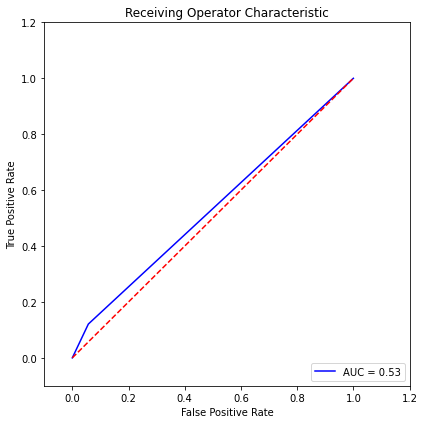

In [0]:
#Calling Decision Tree Model
dt = Decision_Tree(x_train, y_train.values.ravel())
pred_DT = dt.predict(x_test)
con_matrix(y_test, pred_DT,"Decision Tree")
#feat_imp_dt_rf(x_train,dt)
results_DT=score_calc(dt, x_test, y_test, pred_DT,"Decision Tree")
print_model_stats(dt, x_train, y_train, x_test, y_test)

The Confusion Matrix of the Random Forest 
 1 0
1 0 91
0 0 1630
/databricks/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
 _warn_prf(average, modifier, msg_start, len(result))
--------------------------------------------------------------------
Model Statistics on Validation dataset
Log Loss Without for validation sample: 0.22531747946089212
ROC-AUC score for the validation sample: 0.612
ROC curve for the Validaton Sample

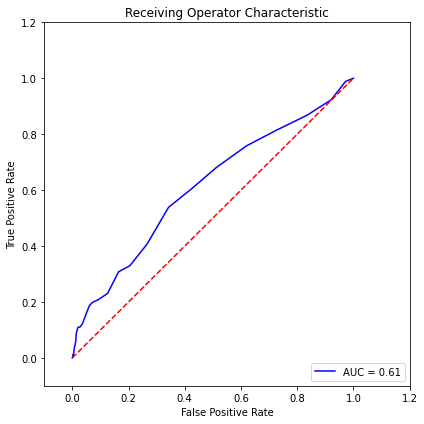

In [0]:
#calling random forecast model
rf = Random_Forest(x_train, y_train.values.ravel())
pred_RF = rf.predict(x_test)
con_matrix(y_test, pred_RF,"Random Forest")
results_RF=score_calc(rf, x_test, y_test, pred_RF,"Random Forest")
print_model_stats(rf, x_train, y_train, x_test, y_test)

The Confusion Matrix of the Graident Boost 
 1 0
1 0 91
0 6 1624
--------------------------------------------------------------------
Model Statistics on Validation dataset
Log Loss Without for validation sample: 0.19834480297274862
ROC-AUC score for the validation sample: 0.701
ROC curve for the Validaton Sample

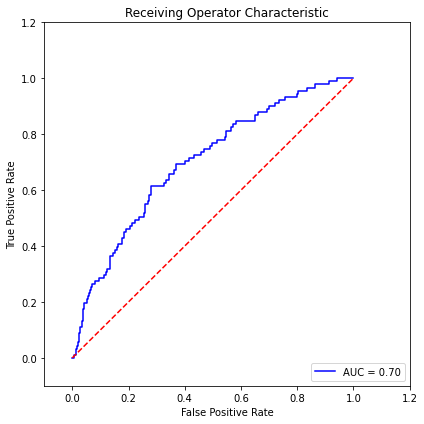

In [0]:
#calling random forecast model
gbm = Gradient_Boost(x_train, y_train.values.ravel())
pred_GBM = gbm.predict(x_test)
con_matrix(y_test, pred_GBM,"Graident Boost")
results_GBM=score_calc(gbm, x_test, y_test, pred_GBM,"Graident Boost")
print_model_stats(gbm, x_train, y_train, x_test, y_test)

In [0]:
prediction_probability = gbm.predict_proba(x_test)
prediction_probability

Out[50]: array([[0.9886806 , 0.0113194 ],
 [0.95348075, 0.04651925],
 [0.96657558, 0.03342442],
 ...,
 [0.89160828, 0.10839172],
 [0.9748774 , 0.0251226 ],
 [0.98033401, 0.01966599]])

In [0]:
#getting IDs for users
x_test = x_test.join(loan_application[['SK_ID_CURR']], how='left')

In [0]:
gbm.classes_

Out[51]: array([0, 1], dtype=uint8)

In [0]:
predProb_list = []

for i in range(0,len(prediction_probability)):
  predProb_list.append(prediction_probability[i][1])
  
#validating
predProb_list

Out[52]: [0.011319402218963564,
 0.046519245142854465,
 0.033424415492024726,
 0.05003213434312602,
 0.016038495384451335,
 0.03342637916133214,
 0.07298999294131266,
 0.06981332050507179,
 0.05402671603165988,
 0.043196416742652476,
 0.02069261834913763,
 0.016428540070624165,
 0.02553445304383062,
 0.06924491540588684,
 0.03645599910697776,
 0.020032565008951782,
 0.05808405859880753,
 0.03772816158627544,
 0.014329403763042488,
 0.04426134479619445,
 0.07905212655361568,
 0.027068821024117277,
 0.12979172694408656,
 0.03566187162532983,
 0.03454654044732528,
 0.01703275247391791,
 0.11463794614913672,
 0.02796531109987508,
 0.04515563483750034,
 0.019266815727561597,
 0.03302309404914854,
 0.0469566136013942,
 0.03299671305210348,
 0.025143508427318325,
 0.07473459040844088,
 0.013505842760582228,
 0.08292101927912514,
 0.06639922815123947,
 0.037339154319053006,
 0.1737930539885957,
 0.2857904456246522,
 0.13149875562001187,
 0.06488600059962443,
 0.0156300599326233,
 0.14375882623001435,
 0.016996333139270136,
 0.008647915563147951,
 0.015801163749978094,
 0.09467325805383396,
 0.0723639878132093,
 0.2761330865568307,
 0.05931258538733183,
 0.01264288814857366,
 0.04171299715048542,
 0.0178114536888891,
 0.013123872887512045,
 0.019889093113156567,
 0.019857490590118494,
 0.025399842600577642,
 0.06872004258799225,
 0.07784015113932045,
 0.012239065622008941,
 0.01839117550902314,
 0.05989670806942716,
 0.013579812438128952,
 0.00909054389407997,
 0.03260335215693821,
 0.05666411802067434,
 0.06143835928760627,
 0.08175400656573753,
 0.02450003142604829,
 0.07745767083186898,
 0.01618420826339132,
 0.02920777024225039,
 0.10352477423823003,
 0.019263119241955253,
 0.19439765010242183,
 0.11154775221434632,
 0.1822727572285884,
 0.0858923753047104,
 0.023404572858136987,
 0.0110571226300974,
 0.04130595523548202,
 0.03803763919545478,
 0.03521819293385679,
 0.047208389778706346,
 0.07946090056586451,
 0.013928656683457078,
 0.0362897436945722,
 0.041542408656863185,
 0.03756787555470237,
 0.03716940354160253,
 0.08862382936386716,
 0.047659437937192795,
 0.08024696051867988,
 0.02130765963614434,
 0.027362510391335092,
 0.03955838561569278,
 0.39199885313392735,
 0.05401886683762257,
 0.03411165343328206,
 0.049567059255833996,
 0.030739999296724854,
 0.059631870040163196,
 0.024783474555369323,
 0.043249796414445305,
 0.016572285948085293,
 0.020316901118345203,
 0.053465035106142186,
 0.08064915144688913,
 0.1656767549503587,
 0.06229515025851542,
 0.051269616829316224,
 0.02519218372599865,
 0.06063868413721928,
 0.017266237957387732,
 0.023326350402570837,
 0.10951467708752864,
 0.07146372056393138,
 0.03835152601083477,
 0.06660198670442073,
 0.08888072160055105,
 0.05330178879725612,
 0.019575912779860448,
 0.06918461324835591,
 0.018522362447125795,
 0.04147045625716487,
 0.015194834869130673,
 0.023942625805409554,
 0.026188437959666664,
 0.10704270091920427,
 0.018454541414001727,
 0.05143550772835017,
 0.027072081617956652,
 0.017039399307968457,
 0.01565391883907731,
 0.15871369270645147,
 0.06908461731591319,
 0.08363069338491841,
 0.11600178630227137,
 0.049799083806667914,
 0.031693720286171845,
 0.046492545538936406,
 0.04186339352561357,
 0.04285889523846548,
 0.014075426645636815,
 0.026263016403468557,
 0.20380020267887194,
 0.06140920537162999,
 0.010904936202546574,
 0.01812449738752467,
 0.013987628391823726,
 0.30236557752132287,
 0.14260731343380373,
 0.025026865712646878,
 0.07933722815269989,
 0.018938682736849604,
 0.017946637799799197,
 0.010851267628911367,
 0.008925580159675414,
 0.07734702696328426,
 0.029292949082683675,
 0.03206061116489542,
 0.03542544362820112,
 0.040531820576719446,
 0.0865091319556901,
 0.07920200258660191,
 0.17028797994106756,
 0.04376326592434584,
 0.21134028634934732,
 0.025719941864772715,
 0.0429882915615762,
 0.0400377842274533,
 0.09079629081486747,
 0.03903672937439135,
 0.03168165174392338,
 0.01660827362428787,
 0.4022501818719148,
 0.060127697175289554,
 0.01

In [0]:
predictions_default = pred_GBM
predictions_default

Out[53]: array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [0]:
id_list = list(x_test['SK_ID_CURR'])

In [0]:
prediction_df = pd.DataFrame()
prediction_df['prediction_label'] = list(predictions_default)
prediction_df['prediction_probability'] = list(predProb_list)
prediction_df['predicted_class'] = 'None'
prediction_df['Company_ID'] = id_list

In [0]:
#Assinging class label
prediction_df.loc[prediction_df['prediction_label']==1,'predicted_class']='NPA'
prediction_df.loc[prediction_df['prediction_label']==0,'predicted_class']='Non NPA'

prediction_df['predicted_class'].value_counts()

Out[76]: Non NPA 1715
NPA 6
Name: predicted_class, dtype: int64

In [0]:
prediction_df

Out[77]:

,prediction_label,prediction_probability,predicted_class,Company_ID
0,0,0.011319,Non NPA,439856
1,0,0.046519,Non NPA,297982
2,0,0.033424,Non NPA,451647
3,0,0.050032,Non NPA,447226
4,0,0.016038,Non NPA,303419
...,...,...,...,...
1716,0,0.023404,Non NPA,114341
1717,0,0.022541,Non NPA,137856
1718,0,0.108392,Non NPA,302914
1719,0,0.025123,Non NPA,310901


In [0]:
#saving df to datalake
prediction_df.to_csv("/dbfs/mnt/agorizeblob/loan_data/prediction_NPA.csv", index=False)